# Question - Support Vector machine
**contain three subsections**
1. Hard margin svm using cvxpy
2. soft margin svm using cvxpy
3. svm on MNIST dataset

In [2]:
# importind and installing dependencies
# !pip install cvxpy
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from cvxpy import *

In [33]:
# helper functions
def reds_blues(X, Y):
    reds = []
    blues = []
    for i in range(Y.shape[0]):
        if Y[i] == 1:
            reds.append(X[i])
        else:
            blues.append(X[i])
    reds = np.array(reds)
    blues = np.array(blues)
    return reds,blues

def svm_hard_margin(X,y,blues,reds,C = None):
    d = X.shape[1]
    uni,counts = np.unique(y,return_counts = True)
    m = counts[0]
    n = counts.sum()-m
    w = Variable((d,1))
    b = Variable()

#     objective_function = Minimize((norm(w,2)))
    objective_function = Minimize((1/2)*norm(w,2))

    blue_constraints = [w.T @ blues[i] + b >= 1  for i in range(m)]
    red_constraints = [w.T @ reds[i] + b <= -1 for i in range(n)]
    

#     constraints = [y[i](w.T @ X[i] + b) >= 1  for i in range(X.shape[0])]
#     constraints = [(y[i]*((w.T @ X[i]) + b) -1) >= 0 for i in range(X.shape[0])]

    constraints = blue_constraints +  red_constraints  

    prob = Problem(objective_function, constraints)

    prob.solve()
#     print("Problem Status: " ,prob.status)
    w = w.value
    b = b.value
#     print("value of w: ")
#     print(w)
#     print("value of b: ",b)
    return w,b

def svm_soft_margin(X,y,blues,reds,C = None):
    d = X.shape[1]
    uni,counts = np.unique(y,return_counts = True)
    m = counts[0]
    n = counts.sum()-m
    w = Variable((d,1))
    b = Variable()
    eps = Variable(X.shape[0])

#     objective_function = Minimize((norm(w,2)))
    if C == None:
        objective_function = Minimize((1/2)*norm(w,2))
        blue_constraints = [w.T @ blues[i] + b >= 1  for i in range(m)]
        red_constraints = [w.T @ reds[i] + b <= -1 for i in range(n)]
        constraints = blue_constraints +  red_constraints
    else:
        firstTerm_soft = 0.5*square(norm(w))
        secondTerm_soft = C*sum(eps)
#         constraints_soft = [(y_new[i]*(np.sum(w_soft.T * X_new[i]) + b_soft) -1 + e_soft[i] ) >= 0 for i in range(X_new.shape[0])]
        objective_function = Minimize(firstTerm_soft + secondTerm_soft)
#         objective_function = Minimize((1/2)*norm(w,2) + C * sum(eps))
        constraints = [(y[i]*(w.T @ X[i] + b) -1 + eps[i] ) >= 0 for i in range(X.shape[0])]

#     constraints = [y[i](w.T @ X[i] + b) >= 1  for i in range(X.shape[0])]
#     constraints = [(y[i]*((w.T @ X[i]) + b) -1) >= 0 for i in range(X.shape[0])]

    prob = Problem(objective_function, constraints)

    prob.solve()
#     print("Problem Status: " ,prob.status)
    w = w.value
    b = b.value
        
    return w,b

def visualise_svm(reds,blues,w,b):
    
    plt.scatter(reds[:, 0], reds[:, 1], c = 'r')
    plt.scatter(blues[:, 0], blues[:, 1], c = 'b')
    m = (-b - w[0]*blues)/w[1]
    x = np.linspace(-5, 4, 10)
    plt.plot(x, (-b - (w[0]*x))/w[1] , 'm')

    plt.plot(x, (-b - (w[0]*x)+1)/w[1] ,'g--')

    plt.plot(x, (-b - (w[0]*x)-1)/w[1] , 'y--')

    plt.show()

## subsection 1 - Hard margin svm using cvxpy
In this subsection, you will work on a synthetic dataset and visualize the boundary predicted by SVM.
**Please note that you cannot use inbuilt sklearn function for SVM in this sub-section**. You can only use a QCQP (Quadratically Constrained Quadratic Program) solver like CVXPY. 
Note that in this section you are expected to show how you derived the Quadratically Constrained form(which can be passed into the solver) from the basic principles of SVM algorithm.In the next cells you are required to visualize the boundary predicted by the solver.

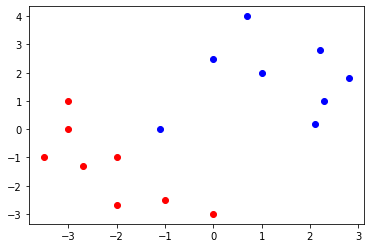

(16, 2) (16,)
(8, 2) (8, 2)
[-1  1] [8 8]


In [16]:
# Create Synthetic Data and visualize the points
X = np.array([[-3.5, -1], [-3, 0], [-3, 1], [-2.7, -1.3], [-2, -1], [-2, -2.7], 
              [-1, -2.5], [0, -3], [-1.1, 0], [0, 2.5], [1, 2], [0.7, 4], 
              [2.1, 0.2], [2.3, 1], [2.8, 1.8], [2.2, 2.8]])
y = np.array([1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1])

reds, blues = reds_blues(X, y)
plt.scatter(reds[:, 0], reds[:, 1], c = 'r')
plt.scatter(blues[:, 0], blues[:, 1], c = 'b')
plt.show()
print(X.shape,y.shape)
print(blues.shape,reds.shape)
uni,counts = np.unique(y,return_counts = True)
print(uni,counts)

**derivation the Quadratic Constrained Quadratic form of SVM without soft constraints and visualising hyperplane** <br>
For derivation taking example of two classes `+1` and `-1`. the key is to seperate the data with maximum margin.
Equation of hyperplane can be given as $y=\omega^{\top} x+b$ where `w` is weights, `x` is features and `b` is the bias term<br>
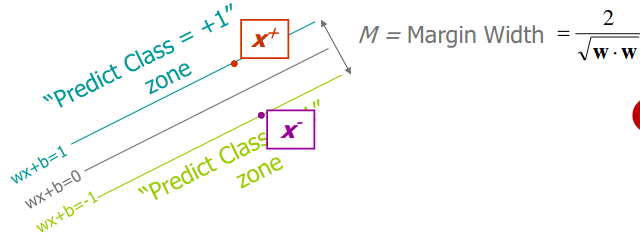<br>
For maximising the distance we will use l2 norm distance measure as <br>
$ d1=\frac{\left|\omega^{\top} x+b\right|}{\| w |\mid}$ for one sideof the hyperplane<br>
$ d2=\frac{\left|\omega^{\top} x+b\right|}{\| w |\mid}$ for the other side of the hyperplane<br>
therefore the total width becomes M = d1 + d2<br>
    $ M  =\frac{1}{\| w |\mid} + \frac{1}{\| w |\mid}$(since distance is absolute)<br>
    therefore maximise $ M  =\frac{2}{\| w |\mid}$<br>
    whch is equivalent to minimising the following objective functiin <br>
    $\widehat{\mathbf{w}}=\arg \min _{\mathbf{w} \in \mathbb{R}^{m}} \frac{1}{2}\|\mathbf{w}\|^{2}$<br>
    subjected to constraint<br>
    $y_{i}\left(w^{\top}(x+b)) \geqslant 1\right.$

Problem Status:  optimal

[[1.73913044]
 [1.30434783]]
2.9130434807856536


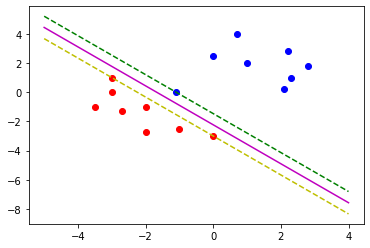

In [18]:
w,b = svm_hard_margin(X,y,blues,reds)
'''Problem Status:  optimal

value of w: 
[[1.73913043]
 [1.30434783]]
value of b:  2.913043478318835'''
print(w)
print(b)
visualise_svm(reds,blues,w,b)

**plotting only the support vectors along with the boundary, and margins.**

[array([-3.,  1.]), array([ 0., -3.])] [array([-1.1,  0. ])]


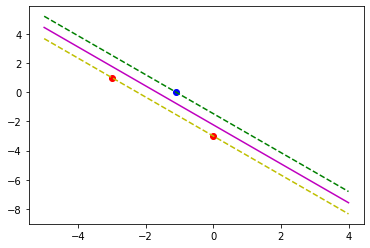

In [22]:
# calculating support vectors
sv_red = []
sv_blue = []
for x in X:
    t = (np.dot(w.T,x) + b)
    if(t[0].round(3) == -1.0):
        sv_red.append(x)
    if t[0].round(3) == 1.0:
        sv_blue.append(x)
print(sv_red,sv_blue)
sv_blue = np.array(sv_blue)
sv_red = np.array(sv_red)
visualise_svm(sv_red,sv_blue,w,b)

**In the next cell add the following points:**
* (-4, -10) with label 1
* (4, 4) with label -1
Is the decision boundary changed after adding the points? Explain your observations theoretically


**no the decesion boundary does not changes after adding given extra points because training SVM depends only upon support vectors and given data points do not form a suport vector**

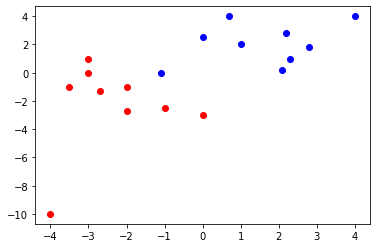

(18, 2) (18,)
(9, 2) (9, 2)


In [27]:
# Re-create the Synthetic Data by adding the points and visualize the points
# X = np.append(X,[(-4,-10),(4,4)])
X_new = np.concatenate((X, [[-4,-10],[4,4]]), axis=0)
y_new = np.append(y, [1,-1])
reds_new, blues_new = reds_blues(X_new, y_new)
plt.scatter(reds_new[:, 0], reds_new[:, 1], c = 'r')
plt.scatter(blues_new[:, 0], blues_new[:, 1], c = 'b')
plt.show()
print(X_new.shape,y_new.shape)
print(reds_new.shape,blues_new.shape)
# print(X_new)
# print(y_new)

Problem Status:  optimal



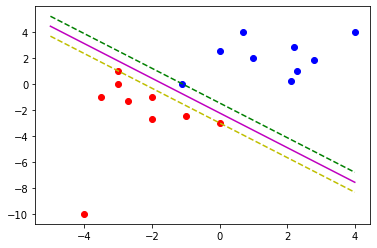

In [28]:
# plotting decesion boundary after adding new data
w_new,b_new = svm_hard_margin(X_new,y_new,blues_new,reds_new)
visualise_svm(reds_new,blues_new,w_new,b_new)

## subsection 2 - Soft margin svm using cvxpy

In the next cell you are required to modify your framing of optimisation problem to incorporate soft constraints also known as slack. Plot the decision boundary, w and margin lines for various values of C: $0.01$, $0.1$, $3$, $10$, $100$.
Explain your results theoretically. How does the boundary change with varying values of C? Why?
**Note: Use the modified X and y i.e after adding points in previous cell**

**soft margin cost function sucjected to folowing constraints** <br>
where ε i are slack variables which measure the deviation of data points from the marginal hyperplane
and allow some data points to violate the initial constraint.
Therefore, the objective is to minimise :<br>
$ \frac{1}{2}||w||^2 + C \sum \epsilon i$
<br>
subject to :<br>
$y i (w . T x i + b) ≥ 1 − ξ i , ξ i ≥ 0$

In [29]:
# modified X and y
print(X_new.shape,y_new.shape)
print(reds_new.shape,blues_new.shape)
# print(X_new)
# print(y_new)

(18, 2) (18,)
(9, 2) (9, 2)



********for C = 0.001********

value of w  [[-0.03519998]
 [-0.03879998]]
value of b  -0.08408786252877197


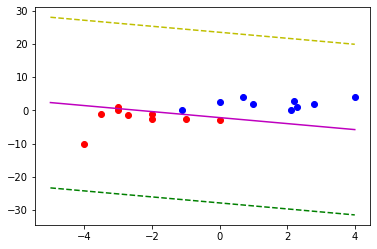


********for C = 0.01********

value of w  [[-0.35199998]
 [-0.38799998]]
value of b  -0.11938557293887768


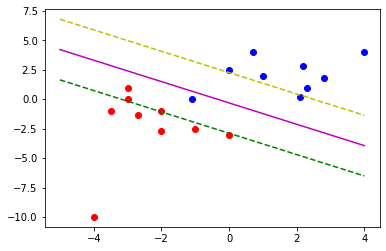


********for C = 0.1********

value of w  [[-3.52000232]
 [-3.88000255]]
value of b  -0.47236295069646483


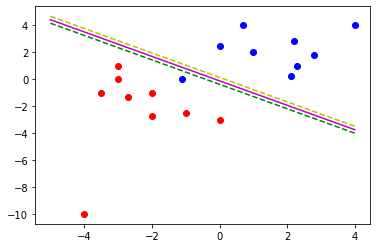


********for C = 3********

value of w  [[-105.60083238]
 [-116.4009175 ]]
value of b  -11.846289040288369


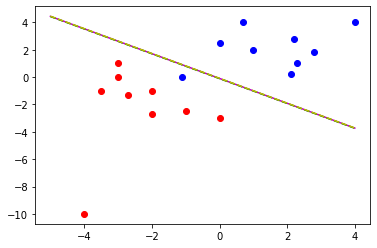


********for C = 10********

value of w  [[-352.8999489 ]
 [-388.99199202]]
value of b  -39.40255812912603


/home/anchal_soni/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1245: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


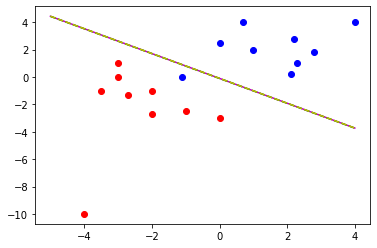

In [37]:
C = [0.001, 0.01, 0.1, 3, 10]
for c in C:
    w_soft,b_soft = svm_soft_margin(X_new,y_new,blues_new,reds_new,C = c)
    print("\n********for C = {}********\n".format(c))
    print("value of w ",w_soft)
    print("value of b ",b_soft)
    visualise_svm(reds_new,blues_new,w_soft,b_soft)

# conclusion
The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words C behaves as a regularization parameter in the SVM.

Take the case of C = 100 and remove the support vectors. Does the boundary change after the deletion?
Explain why? Show your results by appropriate plots?

In [ ]:
# finding support vectors
sv_red = []
sv_blue = []
sv2 = []
for x in X:
    t = (np.dot(w.T,x) + b)
    if(t[0].round(3) == -1.0):
        sv_red.append(x)
    if t[0].round(3) == 1.0:
        sv_blue.append(x)
print(sv_red,sv_blue)
sv2 = sv_red+sv_blue
sv_blue = np.array(sv_blue)
sv_red = np.array(sv_red)

# removing support vectors
Xdel = X_new
for pt in sv2:
    Xdel = np.delete(Xdel, np.where(Xdel == pt),0)
print(Xdel)

# svm for c = 100
w_soft,b_soft = svm_soft_margin(X_del,y_del,blues_del,reds_del,C = 100)
print("\n********for C = 100********\n")
print("value of w ",w_soft)
print("value of b ",b_soft)
visualise_svm(reds_del,blues_del,w_soft,b_soft)


## subsection 3 - SVM on MNIST dataset

In [38]:
!pip install python-mnist
!rm -rf samples
!mkdir samples
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -P samples/
!gunzip samples/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -P samples/
!gunzip samples/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -P samples/
!gunzip samples/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -P samples/
!gunzip samples/t10k-labels-idx1-ubyte.gz

In [39]:
# Import Relevant Packages
from sklearn.svm import SVC
from mnist.loader import MNIST

In [40]:
mndata = MNIST('samples')

# Load training dataset
images, labels = mndata.load_training()
l = len(labels)
images_train = np.array(images)
labels_train = np.array(labels)

print(images_train.shape)
print(labels_train.shape)

(60000, 784)
(60000,)


In [41]:
# Load testing dataset
images, labels = mndata.load_testing()
l = len(labels)
images_test = np.array(images)
labels_test = np.array(labels)

print(images_test.shape)
print(labels_test.shape)

(10000, 784)
(10000,)


#### using only the digits 0, 1, 2 instead of using all the 10 digits`

(18623, 784) (18623,)
(3147, 784) (3147,)


(-0.5, 27.5, 27.5, -0.5)

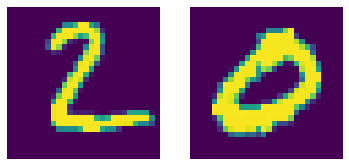

In [43]:
train_mask = np.isin(labels_train, [0,1,2])
test_mask = np.isin(labels_test, [0,1,2])
images_train, labels_train = images_train[train_mask], labels_train[train_mask]
images_test, labels_test = images_test[test_mask], labels_test[test_mask]
print(images_train.shape,labels_train.shape)
print(images_test.shape,labels_test.shape)
img_size = 28
plt.subplot(1, 2, 1)
plt.imshow(images_test[0].reshape(img_size, img_size))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(images_train[900].reshape(img_size, img_size))
plt.axis('off')

- Tweak different parameters like the C Parameter and gamma parameter of the Linear SVM and report the results.
- Experiment different kernels for classification and report the results.

Report accuracy score, F1-score, Confusion matrix and any other metrics you feel useful.

In [47]:
from sklearn import datasets, svm, metrics
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
C = [0.001, 0.01, 0.1, 3, 10, 100]
for c in C:
    clf = SVC(C = c, kernel = 'linear')
    clf.fit(images_train, labels_train)
    predicted = clf.predict(images_test)
#     predicted[:10]
    print("Accuracy using linear classifier:",metrics.accuracy_score(labels_test, predicted))
    print("confusion matrix using linear classifier is ")
    print(confusion_matrix(labels_test, predicted))    print(f"Classification report for classifier {clf}:\n"
      f"{metrics.classification_report(labels_test, predicted)}\n")

Accuracy using linear classifier: 0.9809342230695901
confusion matrix using linear classifier is 
Classification report for classifier SVC(C=0.001, kernel='linear'):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.96      0.97      1032

    accuracy                           0.98      3147
   macro avg       0.98      0.98      0.98      3147
weighted avg       0.98      0.98      0.98      3147


Accuracy using linear classifier: 0.9809342230695901
confusion matrix using linear classifier is 
Classification report for classifier SVC(C=0.01, kernel='linear'):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.96      0.97      1032

    accuracy                           0.98      3147
   macro avg   

In [49]:
clf2 = SVC(degree = 3, kernel = 'poly')
clf2.fit(images_train, labels_train)
predicted = clf2.predict(images_test)
#     predicted[:10]
print("Accuracy using linear classifier:",metrics.accuracy_score(labels_test, predicted))
print("confusion matrix using linear classifier is ")
print(confusion_matrix(labels_test, predicted))    
print(f"Classification report for classifier {clf}:\n"
f"{metrics.classification_report(labels_test, predicted)}\n")

Accuracy using linear classifier: 0.9939625039720369
confusion matrix using linear classifier is 
[[ 975    2    3]
 [   0 1132    3]
 [   7    4 1021]]
Classification report for classifier SVC(C=100, kernel='linear'):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032

    accuracy                           0.99      3147
   macro avg       0.99      0.99      0.99      3147
weighted avg       0.99      0.99      0.99      3147




In [50]:
clf3 = SVC(kernel = 'sigmoid')
clf3.fit(images_train, labels_train)
predicted = clf3.predict(images_test)
#     predicted[:10]
print("Accuracy using linear classifier:",metrics.accuracy_score(labels_test, predicted))
print("confusion matrix using linear classifier is ")
print(confusion_matrix(labels_test, predicted))    
print(f"Classification report for classifier {clf}:\n"
f"{metrics.classification_report(labels_test, predicted)}\n")

Accuracy using linear classifier: 0.9504289799809342
confusion matrix using linear classifier is 
[[ 938    1   41]
 [   0 1110   25]
 [  46   43  943]]
Classification report for classifier SVC(C=100, kernel='linear'):
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.91      0.92      1032

    accuracy                           0.95      3147
   macro avg       0.95      0.95      0.95      3147
weighted avg       0.95      0.95      0.95      3147




In [51]:
clf4 = SVC(kernel = 'rbf')
clf4.fit(images_train, labels_train)
predicted = clf4.predict(images_test)
#     predicted[:10]
print("Accuracy using linear classifier:",metrics.accuracy_score(labels_test, predicted))
print("confusion matrix using linear classifier is ")
print(confusion_matrix(labels_test, predicted))    
print(f"Classification report for classifier {clf}:\n"
f"{metrics.classification_report(labels_test, predicted)}\n")

Accuracy using linear classifier: 0.9955513187162377
confusion matrix using linear classifier is 
[[ 979    0    1]
 [   0 1131    4]
 [   8    1 1023]]
Classification report for classifier SVC(C=100, kernel='linear'):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      0.99      1032

    accuracy                           1.00      3147
   macro avg       1.00      1.00      1.00      3147
weighted avg       1.00      1.00      1.00      3147




# conclusion
the linear kernel works fine if your dataset if linearly separable; if your dataset isn't linearly separable chosing the right kernel is f utmost importance.Use linear SVMs (or logistic regression) for linear problems, and nonlinear kernels such as the Radial Basis Function kernel for non-linear problems.
In our case since the data is sigmoid function performs the worst among others chosen kernels.

### references
* https://github.com/Vagif12/ML-Algorithms-From-Scratch/blob/main/SVM%20from%20Scratch.ipynb
* https://medium.com/@ankitnitjsr13/math-behind-support-vector-machine-svm-5e7376d0ee4d
* https://medium.com/@ahlawat.randeep/svm-from-scratch-using-quadratic-programming-90b4dbc5e1d2
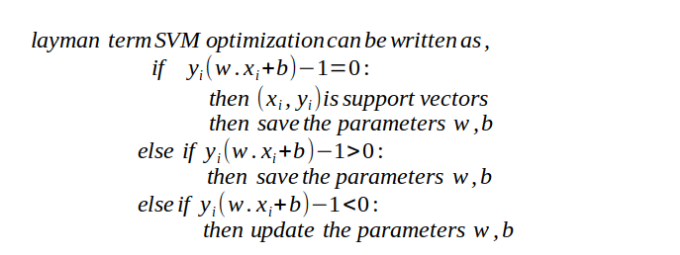